In [1]:
import pandas as pd
import numpy as np
import scipy
from sklearn.preprocessing import MinMaxScaler
from copy import deepcopy
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import pprint
from scipy.stats import pearsonr, spearmanr
from scipy import stats
from scipy.interpolate import CubicSpline
import warnings
warnings.filterwarnings("ignore")
import arviz as az
import scipy
import matplotlib.patches as patches
import statsmodels.stats.api as sms
from sklearn.metrics import r2_score
import scipy.stats.kde as kde

# Read meta data (remove Beijing mice data)

In [3]:
df_meta = pd.read_excel('../../../../../data/meta_data.xlsx', index_col=0)
df_meta = df_meta[df_meta.Vendor != 'Beijing']
df_meta = df_meta[df_meta.Diet == 'Inulin']
df_meta.head()

,MiceID,Vendor,Day,Diet
SampleID,,,,
sample411,GI1,Guangdong,0,Inulin
sample412,GI2,Guangdong,0,Inulin
sample413,GI3,Guangdong,0,Inulin
sample414,GI4,Guangdong,0,Inulin
sample426,GI1,Guangdong,1,Inulin


# Read SCFA

In [4]:
df_scfa = pd.read_excel('../../../../../data/SCFA.xlsx', index_col=0)
df_scfa = df_scfa[['Acetate','Butyrate','Propionate']]
df_scfa = df_scfa.loc[df_meta.index]
df_scfa.head()

,Acetate,Butyrate,Propionate
SampleID,,,
sample411,12.466773,3.631182,2.244246
sample412,8.106016,0.942044,1.438978
sample413,8.612628,2.301846,1.962431
sample414,8.486632,1.867931,2.035315
sample426,8.228369,3.541504,5.440075


In [5]:
df_scfa.corr()

,Acetate,Butyrate,Propionate
Acetate,1.000000,0.640543,0.400002
Butyrate,0.640543,1.000000,0.201395
Propionate,0.400002,0.201395,1.000000


# Read 16S data

In [6]:
df_16S = pd.read_excel('../../../../../data/16S_absolute_abundance.xlsx', index_col=0)
df_16S = df_16S.loc[df_meta.index]
df_16S.columns = [c.replace('/','_slash_').replace(' ','_space_').replace('[','_leftsquarebracket_').replace(']','_rightsquarebracket_').replace('-','_dash_').replace('.','_dot_').replace('(','_leftroundbracket').replace(')','_rightroundbracket_') for c in df_16S.columns]
df_16S.head()

,A2,ASF356,Acetatifactor,Acetatifactor_dash_muris,Acidovorax,Acinetobacter,Acinetobacter_dash_sp_dot__dash_CIP_dash_56_dot_2,Acutalibacter_dash_muris,Adlercreutzia_dash_mucosicola,Adlercreutzia_dash_muris,...,_leftsquarebracket_Eubacterium_rightsquarebracket__dash_ventriosum_dash_group,_leftsquarebracket_Eubacterium_rightsquarebracket__dash_xylanophilum_dash_group,_leftsquarebracket_Ruminococcus_rightsquarebracket__dash_gnavus_dash_group,_leftsquarebracket_Ruminococcus_rightsquarebracket__dash_torques_dash_group,bacterium_dash_enrichment_dash_culture_dash_clone_dash_M153,gut_dash_metagenome,human_dash_gut_dash_metagenome,marine_dash_metagenome,metagenome,mouse_dash_gut_dash_metagenome
SampleID,,,,,,,,,,,,,,,,,,,,,
sample411,18348.368835,52275.541399,43274.454800,346.195638,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,47428.802461,0.0,0.0,0.0,8654.890960,0.000000,0.0,0.0,36004.346394
sample412,21281.217170,175316.693830,191530.954531,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,147955.128897,0.0,0.0,0.0,27361.564933,1013.391294,0.0,0.0,64857.042804
sample413,26771.440390,219525.811195,157951.498299,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,277084.408033,0.0,0.0,0.0,69605.745013,0.000000,0.0,0.0,0.000000
sample414,17807.996879,123718.715159,96538.088343,2811.788981,0.0,0.0,0.0,20619.78586,0.0,0.0,...,0.0,116220.611210,0.0,0.0,0.0,40302.308726,0.000000,0.0,0.0,73106.513503
sample426,46325.294249,92650.588499,174610.724478,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,481070.363358


# Select the 40 most abundant taxa

In [7]:
topX = 40
df_16S_T = df_16S.T
df_16S_T['mean'] = df_16S_T.mean(axis=1)
df_16S_T = df_16S_T.sort_values(by=['mean'],axis=0,ascending=False)
df_16S_T = df_16S_T.drop('mean', axis=1)
df_16S_topX = df_16S_T.iloc[0:topX].T
df_16S_topX.head()

,Muribaculaceae,Akkermansia_dash_muciniphila,Bacteroides_dash_acidifaciens,Bacteroides_dash_uniformis,Parasutterella,Faecalibaculum,Bacteroides,Clostridia_dash_UCG_dash_014,Lachnospiraceae_dash_NK4A136_dash_group,Alloprevotella,...,Ruminococcaceae,Anaerotruncus,Gastranaerophilales,Helicobacter_dash_mastomyrinus,Alistipes,Bilophila,Lachnoclostridium,Peptococcaceae,Lachnospiraceae_dash_UCG_dash_006,Bacteroides_dash_caecimuris
SampleID,,,,,,,,,,,,,,,,,,,,,
sample411,8.398360e+06,2.028706e+05,1.942158e+05,1.187451e+05,2.326435e+05,2.977975e+06,1.500066e+06,6.162282e+04,7.138554e+05,5.197089e+06,...,2.703788e+05,3.835848e+05,102127.713328,145748.363767,1.077361e+06,8308.695322,147479.341959,32542.390010,142286.407383,3.531196e+04
sample412,1.473775e+07,7.843649e+05,3.435396e+05,2.411871e+05,2.807094e+05,4.417373e+06,8.056461e+05,4.043431e+05,4.475136e+06,1.014709e+07,...,1.271806e+06,1.843359e+06,48642.782103,582699.993944,1.485632e+06,32428.521402,544191.124779,176330.085124,755989.905186,5.877670e+04
sample413,2.567783e+07,2.938166e+06,5.742474e+05,2.342501e+05,1.927544e+05,4.286108e+06,7.482618e+05,1.037393e+06,2.635648e+06,3.948787e+06,...,1.927544e+06,2.133684e+06,120471.481753,509995.939422,2.746750e+06,49527.164721,829914.652078,115117.193675,708104.598305,4.149573e+04
sample414,1.713879e+07,9.663181e+05,2.136960e+05,9.091451e+04,4.658197e+05,7.853327e+06,1.724564e+05,1.246560e+05,3.938379e+06,1.939197e+06,...,1.307482e+06,9.925615e+05,25306.100828,687951.037321,9.813144e+05,25306.100828,638276.098659,61859.357579,282116.161081,2.530610e+04
sample426,8.074142e+07,3.588429e+06,1.698820e+08,1.895774e+06,4.507807e+07,4.177472e+07,5.828791e+07,2.173725e+05,3.068160e+06,7.843229e+06,...,1.746107e+05,6.129193e+05,28507.873384,573720.951856,7.269508e+05,71269.683460,737641.223815,138975.882748,288642.218015,1.198043e+07


In [9]:
df_16S_topX.to_csv('independent_variables_top40.csv')

In [8]:
# sample with minimum absolute abundance coverage
(df_16S_topX.sum(axis=1)/df_16S.sum(axis=1)).min()

0.8387350516991756

# Calculate derivative

In [10]:
df_scfa_meta = pd.merge(df_meta, df_scfa, left_index=True, right_index=True, how='inner')
df_scfa_deriv = deepcopy(df_scfa_meta)
for curr_mice in set(df_scfa_deriv.MiceID):
    curr_df = df_scfa_meta[df_scfa_meta.MiceID==curr_mice]
    for scfa in ['Acetate','Butyrate','Propionate']:
        xdata = np.array(curr_df['Day'])
        ydata = np.array(curr_df[scfa])
        cs = CubicSpline(xdata, ydata)
        csd1 = cs.derivative(nu=1)
        ydata_d1 = csd1(xdata)
        df_scfa_deriv.loc[df_scfa_deriv.MiceID==curr_mice, scfa] = ydata_d1
    
df_scfa_deriv = df_scfa_deriv[['Acetate','Butyrate','Propionate']]
df_scfa_deriv.head()

,Acetate,Butyrate,Propionate
SampleID,,,
sample411,-11.331097,-1.456967,1.658890
sample412,4.127181,3.888098,13.125370
sample413,11.745672,5.345893,14.519866
sample414,14.622299,4.552023,11.448899
sample426,1.576644,1.048318,4.307852


In [11]:
df_scfa_deriv.to_csv('response_variables_scfa_deriv.csv')

# Normalize max value of 16S data to 1

In [9]:
# normalize bacteria data using 
bacterial_taxa = list(df_16S_topX.columns)
df_16S_topX = df_16S_topX/df_16S_topX.max().max()
df_16S_topX.head()

,Muribaculaceae,Akkermansia_dash_muciniphila,Bacteroides_dash_acidifaciens,Bacteroides_dash_uniformis,Parasutterella,Faecalibaculum,Bacteroides,Clostridia_dash_UCG_dash_014,Lachnospiraceae_dash_NK4A136_dash_group,Alloprevotella,...,Ruminococcaceae,Anaerotruncus,Gastranaerophilales,Helicobacter_dash_mastomyrinus,Alistipes,Bilophila,Lachnoclostridium,Peptococcaceae,Lachnospiraceae_dash_UCG_dash_006,Bacteroides_dash_caecimuris
SampleID,,,,,,,,,,,,,,,,,,,,,
sample411,0.022591,0.000546,0.000522,0.000319,0.000626,0.008011,0.004035,0.000166,0.001920,0.013980,...,0.000727,0.001032,0.000275,0.000392,0.002898,0.000022,0.000397,0.000088,0.000383,0.000095
sample412,0.039644,0.002110,0.000924,0.000649,0.000755,0.011883,0.002167,0.001088,0.012038,0.027295,...,0.003421,0.004959,0.000131,0.001567,0.003996,0.000087,0.001464,0.000474,0.002034,0.000158
sample413,0.069072,0.007904,0.001545,0.000630,0.000519,0.011529,0.002013,0.002791,0.007090,0.010622,...,0.005185,0.005740,0.000324,0.001372,0.007389,0.000133,0.002232,0.000310,0.001905,0.000112
sample414,0.046103,0.002599,0.000575,0.000245,0.001253,0.021125,0.000464,0.000335,0.010594,0.005216,...,0.003517,0.002670,0.000068,0.001851,0.002640,0.000068,0.001717,0.000166,0.000759,0.000068
sample426,0.217191,0.009653,0.456975,0.005100,0.121258,0.112372,0.156792,0.000585,0.008253,0.021098,...,0.000470,0.001649,0.000077,0.001543,0.001955,0.000192,0.001984,0.000374,0.000776,0.032227


# Simple Correlation

In [60]:
lines = []
for scfa in ['Acetate','Butyrate','Propionate']:
    for t in bacterial_taxa:
        lines.append([scfa,
                     t,
                     pearsonr(df_scfa_deriv[scfa],df_16S_topX[t])[0],
                     spearmanr(df_scfa_deriv[scfa],df_16S_topX[t])[0]]
                    )
df_corr = pd.DataFrame(lines, columns=['SCFA','Variable','Pearson','Spearman'])
df_corr.head()

,SCFA,Variable,Pearson,Spearman
0,Acetate,Muribaculaceae,-0.135717,-0.030025
1,Acetate,Akkermansia_dash_muciniphila,-0.094743,-0.003297
2,Acetate,Bacteroides_dash_acidifaciens,0.035651,0.049439
3,Acetate,Bacteroides_dash_uniformis,-0.083703,0.029721
4,Acetate,Parasutterella,-0.117214,-0.105127


In [61]:
df_corr.to_excel('correlation_top40.xlsx')

# Bayesian regression

## write stan program

In [15]:
json_str ='{\n"N" : %d,\n'%(len(df_16S_topX.index))

# scfa
v = list(df_scfa_deriv['Propionate'].astype(str)) # make a change
json_str += '\"%s\" : [%s],\n'%('dPpadt',','.join(v)) # make a change

# bacteria
for c in df_16S_topX.columns:
    v = list(df_16S_topX[c].astype(str))
    json_str += '\"%s\" : [%s]'%(c,','.join(v))
    if c != df_16S_topX.columns[-1]:
        json_str += ',\n'
json_str += '\n}'
print(json_str)

text_file = open("/Users/liaoc/Documents/cmdstan-2.24.1/examples/mice_scfa_producer/mice_scfa_producer.data.json", "w")
text_file.write("%s" % json_str)
text_file.close()

{
"N" : 112,
"dPpadt" : [1.658889566823928,13.125369631441956,14.519865725126657,11.448898768958525,4.30785209471676,4.865214346770469,5.050139181445348,3.6363598907142958,1.9572692292253948,-0.3765882105274857,1.49105214137893,-1.0191559346538888,-1.184506351639574,0.30073436565462325,1.1748017432742823,1.0880565524888295,-0.6624831633955478,-0.6259958699696645,-2.976594743412104,0.5401777959569066,-0.12541414797288739,-0.4699958276256564,-0.48543666633655164,-0.5206430069080852,0.25713060127066667,0.05127862523436605,0.9558564689984733,0.210318507504472,-0.4568288475049497,-0.20444411403353305,1.0321018527839425,-1.0172606556326127,1.2690814849472973,-0.42941384523883397,-3.2975505997880923,1.0086430692499984,20.789509840878406,11.021309751553892,-0.38338241209664536,2.514472388000391,2.07585459000971,3.8210003840850377,4.621551786087369,4.04149480744545,-3.6479339095507384,2.065840969185746,1.3114014541732937,0.6532584413206056,2.923701429786639,1.841387977042675,-0.715508578316298,

In [16]:
model_str = 'data {\n'
model_str += '\tint<lower=0> N;\n'
model_str += '\tvector[N] dPpadt;\n' # make a change
for c in df_16S_topX.columns:
    model_str += '\tvector[N] %s;\n'%(c)
model_str += '}\nparameters {\n\treal alpha;\n\treal<lower=0,upper=1> sigma;\n'
for c in df_16S_topX.columns:
    model_str += '\treal beta__%s;\n'%(c)
model_str += '}\nmodel {\n\talpha ~ normal(0,1);\n\tsigma ~ uniform(0,1);\n'
for c in df_16S_topX.columns:
    model_str += '\tbeta__%s ~ normal(0,1);\n'%(c)
model_str += '\tdPpadt ~ normal(alpha' # make a change
for c in df_16S_topX.columns:
    model_str += '+beta__%s*%s'%(c,c)
model_str += ', sigma);\n}'
print(model_str)

text_file = open("/Users/liaoc/Documents/cmdstan-2.24.1/examples/mice_scfa_producer/mice_scfa_producer.stan", "w")
text_file.write("%s" % model_str)
text_file.close()

data {
	int<lower=0> N;
	vector[N] dPpadt;
	vector[N] Muribaculaceae;
	vector[N] Akkermansia_dash_muciniphila;
	vector[N] Bacteroides_dash_acidifaciens;
	vector[N] Bacteroides_dash_uniformis;
	vector[N] Parasutterella;
	vector[N] Faecalibaculum;
	vector[N] Bacteroides;
	vector[N] Clostridia_dash_UCG_dash_014;
	vector[N] Lachnospiraceae_dash_NK4A136_dash_group;
	vector[N] Alloprevotella;
	vector[N] Lachnospiraceae;
	vector[N] Escherichia_dash_Shigella;
	vector[N] Parabacteroides_dash_goldsteinii;
	vector[N] Desulfovibrionaceae;
	vector[N] Helicobacter_dash_ganmani;
	vector[N] Oscillospiraceae;
	vector[N] Mucispirillum_dash_schaedleri;
	vector[N] Lachnospiraceae_dash_bacterium_dash_10_dash_1;
	vector[N] Muribaculum;
	vector[N] Roseburia;
	vector[N] Bacteroides_dash_vulgatus_dash_ATCC_dash_8482;
	vector[N] Clostridia_dash_vadinBB60_dash_group;
	vector[N] Colidextribacter;
	vector[N] Ruminococcus_dash_sp_dot__dash_N15_dot_MGS_dash_57;
	vector[N] Oscillibacter;
	vector[N] Lachnospiraceae_da

## write to file

In [247]:
def hpd_grid(sample, alpha=0.05, roundto=2):
    """Calculate highest posterior density (HPD) of array for given alpha. 
    The HPD is the minimum width Bayesian credible interval (BCI). 
    The function works for multimodal distributions, returning more than one mode
    Parameters
    ----------
    
    sample : Numpy array or python list
        An array containing MCMC samples
    alpha : float
        Desired probability of type I error (defaults to 0.05)
    roundto: integer
        Number of digits after the decimal point for the results
    Returns
    ----------
    hpd: array with the lower 
          
    """
    sample = np.asarray(sample)
    sample = sample[~np.isnan(sample)]
    # get upper and lower bounds
    l = np.min(sample)
    u = np.max(sample)
    density = kde.gaussian_kde(sample)
    x = np.linspace(l, u, 2000)
    y = density.evaluate(x)
    #y = density.evaluate(x, l, u) waitting for PR to be accepted
    xy_zipped = zip(x, y/np.sum(y))
    xy = sorted(xy_zipped, key=lambda x: x[1], reverse=True)
    xy_cum_sum = 0
    hdv = []
    for val in xy:
        xy_cum_sum += val[1]
        hdv.append(val[0])
        if xy_cum_sum >= (1-alpha):
            break
    hdv.sort()
    diff = (u-l)/20  # differences of 5%
    hpd = []
    hpd.append(round(min(hdv), roundto))
    for i in range(1, len(hdv)):
        if hdv[i]-hdv[i-1] >= diff:
            hpd.append(round(hdv[i-1], roundto))
            hpd.append(round(hdv[i], roundto))
    hpd.append(round(max(hdv), roundto))
    ite = iter(hpd)
    hpd = list(zip(ite, ite))
    modes = []
    for value in hpd:
        x_hpd = x[(x > value[0]) & (x < value[1])]
        y_hpd = y[(x > value[0]) & (x < value[1])]
        modes.append(round(x_hpd[np.argmax(y_hpd)], roundto))
    return hpd, x, y, modes

## summarize stan output

In [248]:
lines = []
for scfa in ['Acetate','Butyrate','Propionate']:
    fit = az.from_cmdstan(["output_%d_%s.csv"%(i,scfa) for i in np.arange(1,4)])
    
    # alpha
    data = []
    for i in np.arange(0,3):
        data.extend(list(fit.posterior['alpha'][i].values))
    hpd_mu, x_mu, y_mu, modes_mu = hpd_grid(data)
    assert len(hpd_mu) == 1
    (x0, x1) = hpd_mu[0]
    lines.append([scfa, 'alpha', x0, x1, (x0+x1)/2, np.mean(data)/np.std(data), x0*x1>0])

    # beta
    for k,c in enumerate(df_16S_topX.columns):
        var = 'beta__%s'%(c)
        data = []
        for i in np.arange(0,3):
            data.extend(list(fit.posterior[var][i].values))
        hpd_mu, x_mu, y_mu, modes_mu = hpd_grid(data)
        assert len(hpd_mu) == 1
        (x0, x1) = hpd_mu[0]
        lines.append([scfa, var, x0, x1, (x0+x1)/2, np.mean(data)/np.std(data), x0*x1>0])
    
df_stan_output_summary = pd.DataFrame(lines, columns = ['SCFA','Variable','Left','Right','Middle','SNR','Significant'])
df_stan_output_summary.head()

,SCFA,Variable,Left,Right,Middle,SNR,Significant
0,Acetate,alpha,1.63,2.23,1.930,12.709824,True
1,Acetate,beta__Muribaculaceae,-3.00,-1.46,-2.230,-5.739277,True
2,Acetate,beta__Akkermansia_dash_muciniphila,-2.24,0.78,-0.730,-0.968787,False
3,Acetate,beta__Bacteroides_dash_acidifaciens,0.45,2.82,1.635,2.714282,True
4,Acetate,beta__Bacteroides_dash_uniformis,-2.56,0.08,-1.240,-1.859908,False


In [249]:
df_stan_output_summary = df_stan_output_summary[df_stan_output_summary.Variable!='alpha']
df_stan_output_summary['Variable'] = [x.replace('beta__','') for x in df_stan_output_summary['Variable']]
df_stan_output_summary.to_excel('bayesian_regression_summary_top40.xlsx')

In [244]:
# calculate R2
lines = []
for scfa in ['Acetate','Butyrate','Propionate']:
    fit = az.from_cmdstan(["output_%d_%s.csv"%(i,scfa) for i in np.arange(1,4)])
    y_data = df_scfa_deriv[scfa]
    
    posterior_median = []
    data = []
    for i in np.arange(0,3):
        data.extend(list(fit.posterior['alpha'][i].values))
    posterior_median.append(np.median(data))
    
    for k,c in enumerate(df_16S_topX.columns):
        var = 'beta__%s'%(c)
        data = []
        for i in np.arange(0,3):
            data.extend(list(fit.posterior[var][i].values))
        posterior_median.append(np.median(data))
        
    y_pred = posterior_median[0]+df_16S_topX.values.dot(np.array(posterior_median[1:]).reshape(-1,1))
    print(scfa, 'R2 = ', r2_score(y_data, y_pred))

Acetate R2 =  0.04583076439056544
Butyrate R2 =  0.08876790095119147
Propionate R2 =  0.10214667150598411


## plot

In [250]:
df_stan_output_summary = pd.read_excel('bayesian_regression_summary_top40.xlsx', index_col=0)
df_stan_output_summary.head()

,SCFA,Variable,Left,Right,Middle,SNR,Significant
1,Acetate,Muribaculaceae,-3.00,-1.46,-2.230,-5.739277,True
2,Acetate,Akkermansia_dash_muciniphila,-2.24,0.78,-0.730,-0.968787,False
3,Acetate,Bacteroides_dash_acidifaciens,0.45,2.82,1.635,2.714282,True
4,Acetate,Bacteroides_dash_uniformis,-2.56,0.08,-1.240,-1.859908,False
5,Acetate,Parasutterella,-3.64,0.16,-1.740,-1.783539,False


In [251]:
# keep only taxa that have significant associations with at least one out of three SCFA
taxa_to_keep = []
for c in df_16S_topX.columns:
    curr_df = df_stan_output_summary[df_stan_output_summary.Variable==c]
    if np.sum(list(curr_df.Significant))>0:
        print(c, list(curr_df.Significant))
        taxa_to_keep.append(c)
df_stan_output_summary = df_stan_output_summary[df_stan_output_summary.Variable.isin(taxa_to_keep)].reset_index(drop=True)

Muribaculaceae [True, True, True]
Akkermansia_dash_muciniphila [False, False, True]
Bacteroides_dash_acidifaciens [True, True, True]
Lachnospiraceae_dash_NK4A136_dash_group [True, False, False]
Parabacteroides_dash_goldsteinii [True, False, False]
Desulfovibrionaceae [False, False, True]


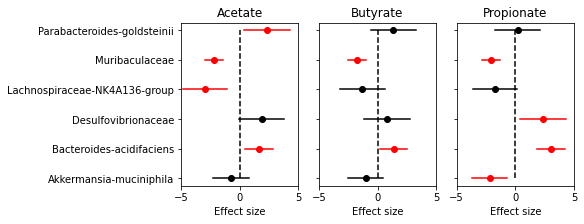

In [252]:
fig, ax = plt.subplots(figsize=(8, 3), nrows=1, ncols=3, constrained_layout=True, sharex=True, sharey=True)

for k,scfa in enumerate(['Acetate','Butyrate','Propionate']):
    curr_df = df_stan_output_summary[df_stan_output_summary.SCFA==scfa]
    curr_df = curr_df[curr_df.Variable.isin(taxa_to_keep)].sort_values(by='Variable', ascending=True).reset_index(drop=True)
    for i in curr_df.index:
        xl = curr_df.loc[i,'Left']
        xr = curr_df.loc[i,'Right']
        xm = curr_df.loc[i,'Middle']
        sig = curr_df.loc[i,'Significant']
        if sig==True:
            ax[k].plot([xl,xr],[i,i],'r-')
            ax[k].plot(xm,i,'ro')
        else:
            ax[k].plot([xl,xr],[i,i],'k-')
            ax[k].plot(xm,i,'ko')
    
    if k==0:
        ax[k].set_yticks(np.arange(len(taxa_to_keep)))
        ax[k].set_yticklabels([t.replace('beta__','').replace('_dash_','-') for t in curr_df.Variable])
    ax[k].plot([0,0],[0,len(taxa_to_keep)-1],'k--')
    ax[k].set_xlim([-5,5])
    ax[k].set_xlabel('Effect size')
    ax[k].set_title(scfa)
        
plt.show()

# Lasso

In [91]:
rows = []
for scfa in ['Acetate','Butyrate','Propionate']:
    dydt = np.asarray(list(df_scfa_deriv[scfa]))
    X = np.asarray(df_16S_topX.values)
    reg = LassoCV(
        eps=1e-4,
        n_alphas=10000,
        cv=5,
        random_state=0,
        max_iter=100000,
        tol=1e-6
    ).fit(X, dydt)
    clf = Lasso(alpha=reg.alpha_, 
                random_state=0,
                max_iter=100000,
                tol=1e-6
               ).fit(X,dydt)
    rows.append([scfa, reg.alpha_, clf.score(X,dydt)]+ list(clf.coef_))
df_lasso = pd.DataFrame(rows, columns=['SCFA','BestAlpha','R2']+list(df_16S_topX.columns)).set_index('SCFA')
df_lasso = df_lasso.loc[:, (df_lasso != 0).any(axis=0)]
df_lasso.head()

,BestAlpha,R2,Muribaculaceae,Akkermansia_dash_muciniphila,Bacteroides_dash_acidifaciens
SCFA,,,,,
Acetate,0.059081,0.016217,-1.780794,-0.000000,0.000000
Butyrate,0.099230,0.022006,-0.611365,-0.000000,0.000000
Propionate,0.031406,0.070224,-1.856254,-1.927978,2.566333


In [22]:
df_lasso = df_lasso.stack().reset_index()
df_lasso = df_lasso[~df_lasso.level_1.isin(['BestAlpha','L1Ratio','R2'])]
df_lasso.columns=['SCFA','Variable','Coefficient']
df_lasso = df_lasso.reset_index(drop=True)
df_lasso.to_excel('lasso_summary_top40.xlsx')

# Elastic net

In [88]:
rows = []
for scfa in ['Acetate','Butyrate','Propionate']:
    dydt = np.asarray(list(df_scfa_deriv[scfa]))
    X = np.asarray(df_16S_topX.values)
    l1_ratio = [1e-4, .1, .3, .5, .7, .9, .95, .99, 1]
    reg = ElasticNetCV(
        eps=1e-4,
        n_alphas=10000,
        cv=5,
        random_state=0,
        max_iter=100000,
        tol=1e-6,
        l1_ratio=l1_ratio
    ).fit(X, dydt)
    clf = ElasticNet(l1_ratio=reg.l1_ratio_, 
                     alpha=reg.alpha_, 
                     random_state=0,
                     max_iter=100000,
                     tol=1e-6,
                    ).fit(X,dydt)
    rows.append([scfa, reg.alpha_, reg.l1_ratio_, clf.score(X,dydt)]+ list(clf.coef_))
df_elasticnet = pd.DataFrame(rows, columns=['SCFA','BestAlpha','L1Ratio','R2']+list(df_16S_topX.columns)).set_index('SCFA')
df_elasticnet = df_elasticnet.loc[:, (df_elasticnet != 0).any(axis=0)]
df_elasticnet.head()

,BestAlpha,L1Ratio,R2,Muribaculaceae,Akkermansia_dash_muciniphila,Bacteroides_dash_acidifaciens,Bacteroides_dash_uniformis,Parasutterella,Faecalibaculum,Bacteroides,...,Ruminococcaceae,Anaerotruncus,Gastranaerophilales,Helicobacter_dash_mastomyrinus,Alistipes,Bilophila,Lachnoclostridium,Peptococcaceae,Lachnospiraceae_dash_UCG_dash_006,Bacteroides_dash_caecimuris
SCFA,,,,,,,,,,,,,,,,,,,,,
Acetate,0.194582,0.0001,0.010638,-0.650962,-0.195898,0.133174,-0.217277,-0.091220,0.003706,0.014808,...,0.004290,0.010090,-0.000163,-0.010272,-0.007383,-0.012972,0.00221,0.021707,-0.000000,0.008669
Butyrate,0.137612,0.0001,0.031384,-0.668519,-0.239517,0.156255,-0.186341,-0.118410,-0.034495,0.009722,...,0.006561,0.006628,-0.005929,-0.005355,-0.006520,-0.013356,0.00055,0.019167,0.002566,0.006057
Propionate,0.005902,0.7000,0.146663,-2.750587,-3.178660,4.098769,-0.000000,-1.303477,0.000000,-4.215720,...,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.00000,0.000000,0.000000,0.000000


In [17]:
df_elasticnet = df_elasticnet.stack().reset_index()
df_elasticnet = df_elasticnet[~df_elasticnet.level_1.isin(['BestAlpha','L1Ratio','R2'])]
df_elasticnet.columns=['SCFA','Variable','Coefficient']
df_elasticnet = df_elasticnet.reset_index(drop=True)
df_elasticnet.to_excel('elasticnet_summary_top40.xlsx')

# Random forest regression

## parameter optimization

In [93]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 30, num = 3)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

lines = []
for scfa in ['Acetate','Butyrate','Propionate']:
    dydt = np.asarray(list(df_scfa_deriv[scfa]))
    X = np.asarray(df_16S_topX.values)

    # grid search
    rf = RandomForestRegressor()
    rf_random = GridSearchCV(
        estimator = rf, 
        param_grid = random_grid, 
        cv = 5, 
        verbose=2, 
        n_jobs = -1)

    # fit the random search model
    rf_random.fit(X, dydt)
    
    # write to table
    lines.append([scfa,
           rf_random.best_params_['n_estimators'],
           rf_random.best_params_['max_features'],
           rf_random.best_params_['max_depth'],
           rf_random.best_params_['min_samples_split'],
           rf_random.best_params_['min_samples_leaf'],
           rf_random.best_params_['bootstrap']
           ])

df_opt_paras = pd.DataFrame(lines, columns=['SCFA','n_estimators','max_features','max_depth','min_samples_split','min_samples_leaf','bootstrap'])
df_opt_paras.head()

Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed: 17.3min
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed: 21.5min finished


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed: 15.0min
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed: 21.3min
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed: 25.5min finished


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed: 13.4min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed: 16.9min
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed: 23.7min
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed: 28.4min finished


,SCFA,n_estimators,max_features,max_depth,min_samples_split,min_samples_leaf,bootstrap
0,Acetate,650,sqrt,30.0,2,1,True
1,Butyrate,200,sqrt,20.0,2,1,True
2,Propionate,200,sqrt,NaN,5,4,True


In [94]:
df_opt_paras.to_excel('optimal_rf_hyperparameters_top40.xlsx')

## run RF using best parameters

In [13]:
df_opt_paras = pd.read_excel('optimal_rf_hyperparameters_top40.xlsx', index_col=0)
df_opt_paras.head()

,SCFA,n_estimators,max_features,max_depth,min_samples_split,min_samples_leaf,bootstrap
0,Acetate,650,sqrt,30.0,2,1,True
1,Butyrate,200,sqrt,20.0,2,1,True
2,Propionate,200,sqrt,NaN,5,4,True


In [26]:
rows = []
for scfa in ['Acetate','Butyrate','Propionate']:
    dydt = np.asarray(list(df_scfa_deriv[scfa]))
    X = np.asarray(df_16S_topX.values)
    regr = RandomForestRegressor(
        random_state=0,
        bootstrap=list(df_opt_paras.loc[df_opt_paras.SCFA==scfa,'bootstrap'])[0],
        max_depth=None if str(list(df_opt_paras.loc[df_opt_paras.SCFA==scfa,'max_depth'])[0])=='nan' else list(df_opt_paras.loc[df_opt_paras.SCFA==scfa,'max_depth'])[0],
        max_features=list(df_opt_paras.loc[df_opt_paras.SCFA==scfa,'max_features'])[0],
        min_samples_leaf=list(df_opt_paras.loc[df_opt_paras.SCFA==scfa,'min_samples_leaf'])[0],
        min_samples_split=list(df_opt_paras.loc[df_opt_paras.SCFA==scfa,'min_samples_split'])[0],
        n_estimators=list(df_opt_paras.loc[df_opt_paras.SCFA==scfa,'n_estimators'])[0],
        n_jobs=-1
    )
    clf = regr.fit(X, dydt)
    rows.append([scfa, clf.score(X, dydt)]+ list(clf.feature_importances_))
df_rf = pd.DataFrame(rows, columns=['SCFA','R2']+list(df_16S_topX.columns))
df_rf.head()

,SCFA,R2,Muribaculaceae,Akkermansia_dash_muciniphila,Bacteroides_dash_acidifaciens,Bacteroides_dash_uniformis,Parasutterella,Faecalibaculum,Bacteroides,Clostridia_dash_UCG_dash_014,...,Ruminococcaceae,Anaerotruncus,Gastranaerophilales,Helicobacter_dash_mastomyrinus,Alistipes,Bilophila,Lachnoclostridium,Peptococcaceae,Lachnospiraceae_dash_UCG_dash_006,Bacteroides_dash_caecimuris
0,Acetate,0.892267,0.043335,0.017602,0.019600,0.010696,0.036536,0.020112,0.041505,0.046288,...,0.043783,0.032258,0.005472,0.017012,0.016846,0.015749,0.028199,0.041682,0.027479,0.015121
1,Butyrate,0.913724,0.071138,0.019110,0.023696,0.016150,0.039257,0.031023,0.038506,0.058270,...,0.029912,0.020834,0.003365,0.009992,0.010327,0.009635,0.020318,0.043845,0.026743,0.006428
2,Propionate,0.598612,0.024605,0.024110,0.042071,0.015040,0.047514,0.019036,0.071049,0.033053,...,0.066911,0.025910,0.001697,0.016477,0.009726,0.013906,0.017821,0.020500,0.037281,0.010464


In [27]:
df_rf = df_rf.set_index('SCFA').stack().reset_index()
df_rf = df_rf[~df_rf.level_1.isin(['R2'])]
df_rf.columns=['SCFA','Variable','Gini']
df_rf = df_rf.reset_index(drop=True)
df_rf.to_excel('rf_importance_top40.xlsx')

## plot

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


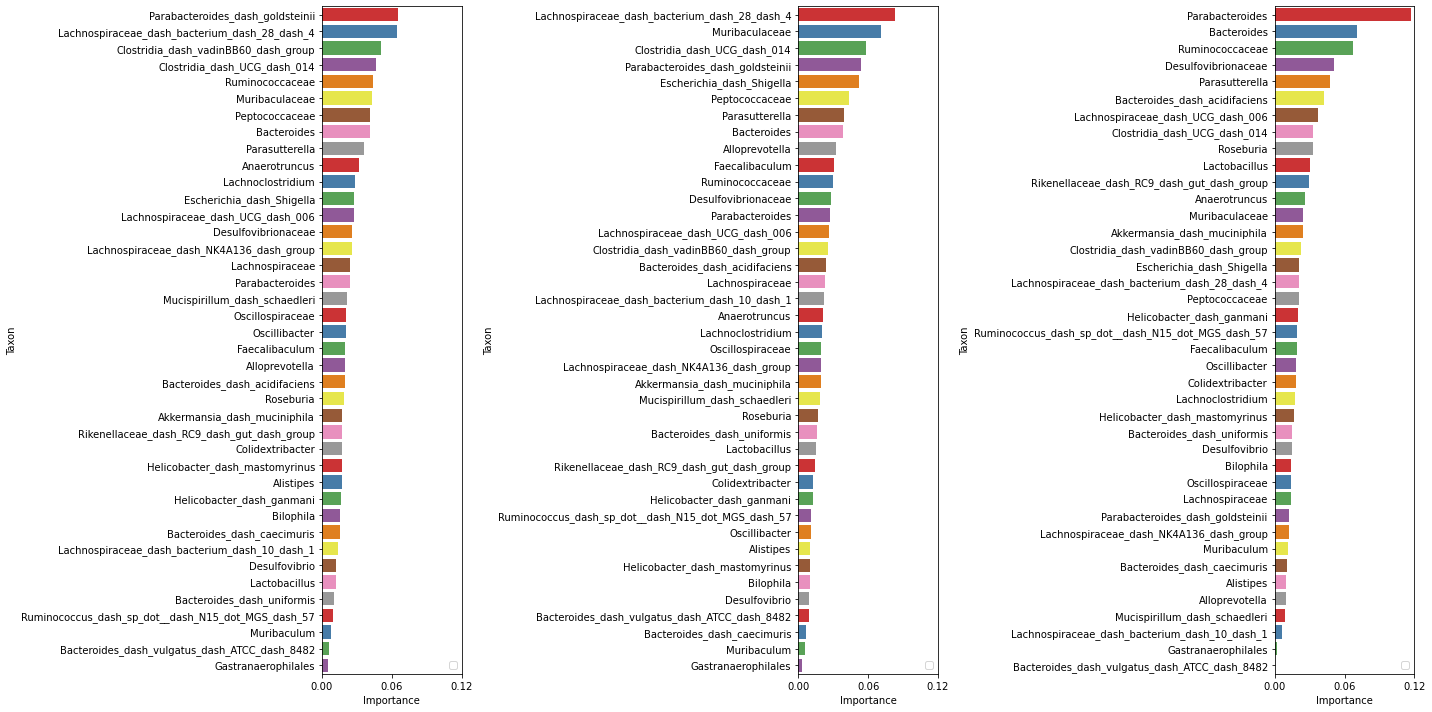

In [38]:
df_rf = pd.read_excel('rf_importance_top40.xlsx', index_col=0).set_index('SCFA')

fig, ax = plt.subplots(figsize=(20, 10), nrows=1, ncols=3, constrained_layout=True)
for k,scfa in enumerate(['Acetate','Butyrate','Propionate']):
    curr_df = df_rf.loc[scfa].reset_index()
    curr_df.columns = ['SCFA','Taxon','Importance']
    curr_df = curr_df.sort_values('Importance',ascending=False)
    _ = sns.barplot(y='Taxon', x='Importance',  data=curr_df, orient='h', ax=ax[k], palette='Set1')
    ax[k].legend(loc='lower right')
    ax[k].set_xlim(0,0.12)
    ax[k].set_xticks([0,0.06,0.12])
plt.tight_layout()

# Combine results

In [2]:
df_corr = pd.read_excel('correlation_top40.xlsx', index_col=0)
df_corr = df_corr.drop('Spearman', axis=1)
df_corr.head()

,SCFA,Variable,Pearson
0,Acetate,Muribaculaceae,-0.135717
1,Acetate,Akkermansia_dash_muciniphila,-0.094743
2,Acetate,Bacteroides_dash_acidifaciens,0.035651
3,Acetate,Bacteroides_dash_uniformis,-0.083703
4,Acetate,Parasutterella,-0.117214


In [3]:
df_elasnet = pd.read_excel('elasticnet_summary_top40.xlsx', index_col=0)
df_elasnet.head()

,SCFA,Variable,Coefficient
0,Acetate,Muribaculaceae,-0.650962
1,Acetate,Akkermansia_dash_muciniphila,-0.195898
2,Acetate,Bacteroides_dash_acidifaciens,0.133174
3,Acetate,Bacteroides_dash_uniformis,-0.217277
4,Acetate,Parasutterella,-0.091220


In [4]:
df_rf = pd.read_excel('rf_importance_top40.xlsx', index_col=0)
df_rf.head()

,SCFA,Variable,Gini
0,Acetate,Muribaculaceae,0.042678
1,Acetate,Akkermansia_dash_muciniphila,0.016252
2,Acetate,Bacteroides_dash_acidifaciens,0.021612
3,Acetate,Bacteroides_dash_uniformis,0.010127
4,Acetate,Parasutterella,0.034985


In [5]:
#df_joined = pd.merge(df_rf, df_corr, left_on=['SCFA','Variable'], right_on=['SCFA','Variable'], how='inner')
df_joined = pd.merge(df_rf, df_elasnet, left_on=['SCFA','Variable'], right_on=['SCFA','Variable'], how='inner')
df_joined.columns = ['SCFA','Taxon','RandomForest','ElasticNet']
df_joined['Taxon'] = [t.replace('_dash_','-').replace('_dot_','.') for t in df_joined['Taxon']]
df_joined.head()

,SCFA,Taxon,RandomForest,ElasticNet
0,Acetate,Muribaculaceae,0.042678,-0.650962
1,Acetate,Akkermansia-muciniphila,0.016252,-0.195898
2,Acetate,Bacteroides-acidifaciens,0.021612,0.133174
3,Acetate,Bacteroides-uniformis,0.010127,-0.217277
4,Acetate,Parasutterella,0.034985,-0.091220


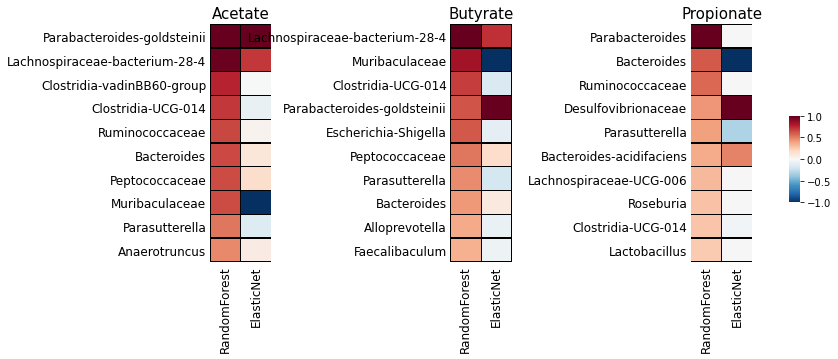

In [10]:
fig, ax = plt.subplots(figsize=(10, 6), nrows=1, ncols=3, constrained_layout=True, sharex=True)
cbar_ax = fig.add_axes([0.94, .45, .015, .2])
for k,scfa in enumerate(['Acetate','Butyrate','Propionate']):
    curr_df = df_joined[df_joined.SCFA==scfa].set_index('Taxon')
    curr_df = curr_df.drop('SCFA', axis=1)
    curr_df = curr_df.sort_values(by='RandomForest', ascending=False)
    curr_df = curr_df.iloc[0:10,:] 
        
    # normalize to -1 and 1
    for c in ['ElasticNet','RandomForest']:
        if c!='RandomForest':
            curr_df.loc[curr_df[c]<0,c] = curr_df.loc[curr_df[c]<0,c]/np.abs(curr_df.loc[curr_df[c]<0,c].min())
        curr_df.loc[curr_df[c]>=0,c] = curr_df.loc[curr_df[c]>=0,c]/curr_df.loc[curr_df[c]>=0,c].max()

    # plot    
    _ = sns.heatmap(curr_df.values, ax=ax[k], cmap='RdBu_r', vmin=-1, vmax=1, cbar = False if k!=2 else True, cbar_ax = None if k!=2 else cbar_ax, linewidths=0.25, linecolor='black')
    ax[k].set_xticklabels(['RandomForest','ElasticNet'], rotation=90, fontsize=12)
    ax[k].set_title(scfa, fontsize=15)
    ax[k].set_yticklabels(curr_df.index, rotation=0, fontsize=12)
    ax[k].tick_params(axis=u'both', which=u'both',length=0)
plt.tight_layout()

In [11]:
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("scfa_producer_top10.pdf", format="pdf")